In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import rc  ### 이 줄
# import scienceplots

# plt.rcParams['font.family'] = 'NanumGothic' # 'AppleGothic' # 폰트 변경
plt.rcParams['axes.unicode_minus'] = False # 축 값 마이너스 깨짐 해결

from datetime import datetime

# import warnings
# warnings.filterwarnings("ignore")

# plt.style.use('seaborn-deep')
# plt.style.use(['science'])
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0

%matplotlib inline

In [95]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()

In [93]:
from sdv.single_table import TVAESynthesizer

# synthesizer = TVAESynthesizer.load(
#     filepath='model/trained_disaster_1024.pkl'
# )

synthetic_data = pd.read_csv('data/synthetic_data_clean.csv')
original_data = pd.read_csv('data/original_data_clean.csv')

In [96]:
metadata.detect_from_dataframe(data=synthetic_data)
metadata

{
    "columns": {
        "tweet_id": {
            "sdtype": "numerical"
        },
        "text_info": {
            "sdtype": "categorical"
        },
        "text_info_conf": {
            "sdtype": "numerical"
        },
        "text_human": {
            "sdtype": "categorical"
        },
        "text_human_conf": {
            "sdtype": "numerical"
        },
        "tweet_text": {
            "sdtype": "categorical"
        },
        "category": {
            "sdtype": "categorical"
        },
        "text_clean": {
            "sdtype": "categorical"
        }
    },
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1"
}

In [101]:
synthetic_data = synthetic_data.dropna(axis=0)
original_data = original_data.dropna(axis=0)

In [102]:
synthetic_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53848 entries, 0 to 55382
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tweet_id         53848 non-null  int64  
 1   text_info        53848 non-null  object 
 2   text_info_conf   53848 non-null  float64
 3   text_human       53848 non-null  object 
 4   text_human_conf  53848 non-null  float64
 5   tweet_text       53848 non-null  object 
 6   category         53848 non-null  object 
 7   text_clean       53848 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 3.7+ MB


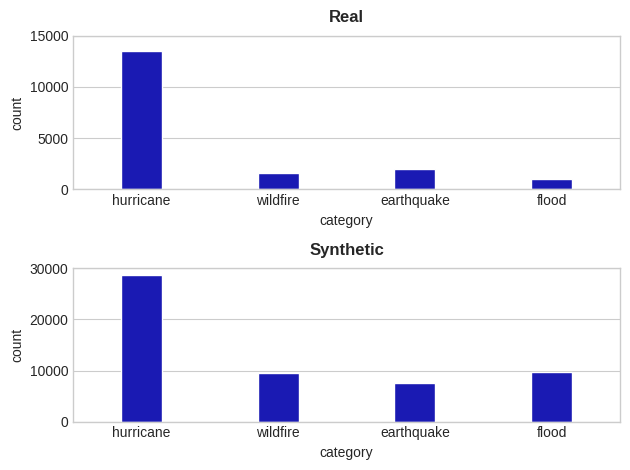

In [87]:
import seaborn as sns

fig, ax =plt.subplots(2,1)
sns.countplot(data=original_data, x='category', ax=ax[0], color='#0000CD', width=0.3).set_title('Real')
sns.countplot(data=synthetic_data, x='category', ax=ax[1], color='#0000CD', width=0.3).set_title('Synthetic')

fig.show()

In [7]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

%matplotlib inline

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/wise/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
synthetic_data['tweet_text']

0        day 23 +12 day intermission swansboro virginia...
1        rt sapphixy prisoners rescue deaf dogs evacuat...
2        spoiler alert jones act problematic needs repe...
3        trump unveils plan fight california wildfires ...
4        https tco cvnrqt51za #style nike air 323085164...
                               ...                        
55378    diego luna takes knee conan gets emotional mex...
55379    unsafe building earthquake result west iran ht...
55380    rescue crews mexico city still trying reach su...
55381    severe thunderstorm warning continues mora nm ...
55382    huge earthquake could strike today says prophe...
Name: tweet_text, Length: 55383, dtype: object

In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
synthetic_data['tweet_text'] = synthetic_data['tweet_text'].apply(clean_text)
synthetic_data['tweet_text']

0        day 23 +12 day intermission swansboro virginia...
1        rt sapphixy prisoners rescue deaf dogs evacuat...
2        spoiler alert jones act problematic needs repe...
3        trump unveils plan fight california wildfires ...
4        https tco cvnrqt51za #style nike air 323085164...
                               ...                        
55378    diego luna takes knee conan gets emotional mex...
55379    unsafe building earthquake result west iran ht...
55380    rescue crews mexico city still trying reach su...
55381    severe thunderstorm warning continues mora nm ...
55382    huge earthquake could strike today says prophe...
Name: tweet_text, Length: 55383, dtype: object

In [ ]:
synthetic_data['tweet_text'].apply(lambda x: len(x.split(' '))).sum()

753013

In [ ]:
X = synthetic_data.tweet_text
y = synthetic_data.category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)
my_tags=['hurricane', 'wildfire', 'earthquake', 'flood']

In [ ]:
%%time
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)


from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.8214866084863075
              precision    recall  f1-score   support

   hurricane       0.77      0.54      0.63      2313
    wildfire       0.86      0.75      0.80      2822
  earthquake       0.80      0.95      0.87      8548
       flood       0.88      0.74      0.80      2932

    accuracy                           0.82     16615
   macro avg       0.83      0.74      0.78     16615
weighted avg       0.82      0.82      0.81     16615

CPU times: user 445 ms, sys: 4.09 ms, total: 449 ms
Wall time: 452 ms


In [ ]:
X = original_data.tweet_text
y = original_data.category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)
my_tags=['hurricane', 'wildfire', 'earthquake', 'flood']

In [ ]:
%%time
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)


from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.807926267281106
              precision    recall  f1-score   support

   hurricane       1.00      0.34      0.51       604
    wildfire       1.00      0.08      0.15       295
  earthquake       0.80      1.00      0.89      4065
       flood       1.00      0.19      0.32       461

    accuracy                           0.81      5425
   macro avg       0.95      0.40      0.47      5425
weighted avg       0.85      0.81      0.76      5425

CPU times: user 158 ms, sys: 0 ns, total: 158 ms
Wall time: 158 ms


In [103]:
# Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text cleaning
import re
import string
import demoji
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

# Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from langdetect import detect, LangDetectException
import contractions
from nltk.tokenize import word_tokenize

# Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

# Transformers library for BERT
import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix

import time

# Set seed for reproducibility
import random
seed_value = 2042
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

# Define stop words for text cleaning
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()

nltk.download('punkt')
nltk.download('wordnet')

/tmp/ipykernel_416288/2054686190.py:59: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")
[nltk_data] Downloading package punkt to /home/wise/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/wise/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<Figure size 640x480 with 0 Axes>

In [104]:
# Clean emojis from text
def remove_emojis(text):
    return demoji.replace(text, '')

# Remove punctuations, stopwords, links, mentions and new line characters
def strip_all_entities(text):
    text = re.sub(r'\r|\n', ' ', text.lower())  # Replace newline and carriage return with space, and convert to lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # Remove links and mentions
    text = re.sub(r'[^\x00-\x7f]', '', text)  # Remove non-ASCII characters
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    # Remove hashtags at the end of the sentence
    new_tweet = re.sub(r'(\s+#[\w-]+)+\s*$', '', tweet).strip()
    
    # Remove the # symbol from hashtags in the middle of the sentence
    new_tweet = re.sub(r'#([\w-]+)', r'\1', new_tweet).strip()
    
    return new_tweet

# Filter special characters such as & and $ present in some words
def filter_chars(text):
    return ' '.join('' if ('$' in word) or ('&' in word) else word for word in text.split())

# Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub(r"\s\s+", " ", text)

# Function to check if the text is in English, and return an empty string if it's not
def filter_non_english(text):
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "unknown"
    return text if lang == "en" else ""

# Expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Lemmatize words
def lemmatize(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Remove short words
def remove_short_words(text, min_len=2):
    words = text.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)

# Replace elongated words with their base form
def replace_elongated_words(text):
    regex_pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    return re.sub(regex_pattern, r'\1\3\4', text)

# Remove repeated punctuation
def remove_repeated_punctuation(text):
    return re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)

# Remove extra whitespace
def remove_extra_whitespace(text):
    return ' '.join(text.split())

def remove_url_shorteners(text):
    return re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', text)

# Remove spaces at the beginning and end of the tweet
def remove_spaces_tweets(tweet):
    return tweet.strip()

# Remove short tweets
def remove_short_tweets(tweet, min_words=3):
    words = tweet.split()
    return tweet if len(words) >= min_words else ""

# Function to call all the cleaning functions in the correct order
def clean_tweet(tweet):
    tweet = remove_emojis(tweet)
    tweet = expand_contractions(tweet)
    tweet = filter_non_english(tweet)
    tweet = strip_all_entities(tweet)
    tweet = clean_hashtags(tweet)
    tweet = filter_chars(tweet)
    tweet = remove_mult_spaces(tweet)
    tweet = remove_numbers(tweet)
    tweet = lemmatize(tweet)
    tweet = remove_short_words(tweet)
    tweet = replace_elongated_words(tweet)
    tweet = remove_repeated_punctuation(tweet)
    tweet = remove_extra_whitespace(tweet)
    tweet = remove_url_shorteners(tweet)
    tweet = remove_spaces_tweets(tweet)
    tweet = remove_short_tweets(tweet)
    tweet = ' '.join(tweet.split())  # Remove multiple spaces between words
    return tweet

In [105]:
# synthetic_data['text_clean'] = [clean_tweet(tweet) for tweet in synthetic_data['tweet_text']]
# original_data['text_clean'] = [clean_tweet(tweet) for tweet in original_data['tweet_text']]

In [106]:
# synthetic_data.to_csv('./data/synthetic_data_clean.csv', index=False)
# original_data.to_csv('./data/original_data_clean.csv', index=False)

In [107]:
synthetic_data['category'].unique()

array(['hurricane', 'wildfire', 'earthquake', 'flood'], dtype=object)

In [108]:
synthetic_data['category'] = synthetic_data['category'].replace(
    {'hurricane':0,
     'wildfire':1,
     'earthquake':2,
     'flood':3})

original_data['category'] = original_data['category'].replace(
    {'hurricane':0,
     'wildfire':1,
     'earthquake':2,
     'flood':3})

In [109]:
X = synthetic_data['text_clean']
y = synthetic_data['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [110]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [111]:
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tf, y_train)
nb_pred = nb_clf.predict(X_test_tf)

In [112]:
category = ['hurricane', 'wildfire', 'earthquake', 'flood']

In [113]:
print('accuracy %s' % accuracy_score(nb_pred, y_test))
print('Classification Report for Naive Bayes:\n',classification_report(y_test, nb_pred, target_names=category))

accuracy 0.8203342618384402
Classification Report for Naive Bayes:
               precision    recall  f1-score   support

   hurricane       0.81      0.95      0.87      5595
    wildfire       0.87      0.75      0.81      1891
  earthquake       0.75      0.54      0.62      1485
       flood       0.87      0.73      0.80      1799

    accuracy                           0.82     10770
   macro avg       0.82      0.74      0.77     10770
weighted avg       0.82      0.82      0.81     10770



In [114]:
X = original_data['text_clean']
y = original_data['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [115]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [116]:
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tf, y_train)
nb_pred = nb_clf.predict(X_test_tf)

In [117]:
category = ['hurricane', 'wildfire', 'earthquake', 'flood']

In [118]:
print('accuracy %s' % accuracy_score(nb_pred, y_test))
print('Classification Report for Naive Bayes:\n',classification_report(y_test, nb_pred, target_names=category))

accuracy 0.8005122367672168
Classification Report for Naive Bayes:
               precision    recall  f1-score   support

   hurricane       0.79      1.00      0.88      2626
    wildfire       1.00      0.16      0.27       316
  earthquake       1.00      0.31      0.48       389
       flood       1.00      0.08      0.15       183

    accuracy                           0.80      3514
   macro avg       0.95      0.39      0.45      3514
weighted avg       0.84      0.80      0.74      3514



In [119]:
def Tokenize(column, seq_len):
    ##Create vocabulary of words from column
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

    ##Tokenize the columns text using the vocabulary
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
    ##Add padding to tokens
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features

In [120]:
synthetic_data['text_len'] = [len(text.split()) for text in synthetic_data.text_clean]
max_len = np.max(synthetic_data['text_len'])
max_len 

21

In [121]:
vocabulary, tokenized_column = Tokenize(synthetic_data["text_clean"], max_len)

In [138]:
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [140]:
EMBEDDING_DIM = 200

In [141]:
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=EMBEDDING_DIM)

In [142]:
print(f"Vocabulary size: {len(vocabulary) + 1}")

Vocabulary size: 38269


In [143]:
VOCAB_SIZE = len(vocabulary) + 1 #+1 for the padding

In [ ]:
# Define an empty embedding matrix of shape (VOCAB_SIZE, EMBEDDING_DIM)
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

# Fill the embedding matrix with pre-trained values from word2vec
for word, token in vocabulary:
    # Check if the word is present in the word2vec model's vocabulary
    if word in word2vec_model.wv.key_to_index:
        # If the word is present, retrieve its embedding vector and add it to the embedding matrix
        embedding_vector = word2vec_model.wv[word]
        embedding_matrix[token] = embedding_vector

# Print the shape of the embedding matrix
print("Embedding Matrix Shape:", embedding_matrix.shape)

IndexError: index 83485 is out of bounds for axis 0 with size 38269

In [158]:
X = tokenized_column
y = synthetic_data['category'].values

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [160]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

In [161]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[    0, 17905],
       [    1,  6050],
       [    2,  4751],
       [    3,  5756]])

In [162]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train),np.array(y_train));

In [163]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[    0, 17905],
       [    1, 17905],
       [    2, 17905],
       [    3, 17905]])

In [164]:
train_data = TensorDataset(torch.from_numpy(X_train_os), torch.from_numpy(y_train_os))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

In [156]:
BATCH_SIZE = 32

In [165]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True) 
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

In [167]:
class Attention(nn.Module):
    def __init__(self, hidden_dim, is_bidirectional):
        super(Attention, self).__init__()
        self.is_bidirectional = is_bidirectional
        # The attention linear layer which transforms the input data to the hidden space
        self.attn = nn.Linear(hidden_dim * (4 if is_bidirectional else 2), hidden_dim * (2 if is_bidirectional else 1))
        # The linear layer that calculates the attention scores
        self.v = nn.Linear(hidden_dim * (2 if is_bidirectional else 1), 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        seq_len = encoder_outputs.size(1)
        # Concatenate the last two hidden states in case of a bidirectional LSTM
        if self.is_bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=-1)
        else:
            hidden = hidden[-1]
        # Repeat the hidden state across the sequence length
        hidden_repeated = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        # Calculate attention weights
        attn_weights = torch.tanh(self.attn(torch.cat((hidden_repeated, encoder_outputs), dim=2)))
        # Compute attention scores
        attn_weights = self.v(attn_weights).squeeze(2)
        # Apply softmax to get valid probabilities
        return nn.functional.softmax(attn_weights, dim=1)


class LSTM_Sentiment_Classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, dropout, is_bidirectional):
        super(LSTM_Sentiment_Classifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = lstm_layers
        self.is_bidirectional = is_bidirectional

        # The Embedding layer that converts input words to embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM layer which processes the embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, lstm_layers, batch_first=True, bidirectional=is_bidirectional)
        # Attention layer to compute the context vector
        self.attention = Attention(hidden_dim, is_bidirectional)
        # Fully connected layer which classifies the context vector into classes
        self.fc = nn.Linear(hidden_dim * (2 if is_bidirectional else 1), num_classes)
        # Apply LogSoftmax to outputs for numerical stability
        self.softmax = nn.LogSoftmax(dim=1)
        # Dropout layer for regularisation
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden):
        # Transform words to embeddings
        embedded = self.embedding(x)
        # Pass embeddings to LSTM
        out, hidden = self.lstm(embedded, hidden)
        # Calculate attention weights
        attn_weights = self.attention(hidden[0], out)
        # Calculate context vector by taking the weighted sum of LSTM outputs
        context = attn_weights.unsqueeze(1).bmm(out).squeeze(1)
        # Classify the context vector
        out = self.softmax(self.fc(context))
        return out, hidden

    def init_hidden(self, batch_size):
        # Factor determines the size of hidden states depending on bidirectionality
        factor = 2 if self.is_bidirectional else 1
        # Initial hidden and cell states are zero
        h0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim).to(DEVICE)
        c0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim).to(DEVICE)
        hidden

In [ ]:
NUM_CLASSES = 5 #We are dealing with a multiclass classification of 5 classes
HIDDEN_DIM = 100 #number of neurons of the internal state (internal neural network in the LSTM)
LSTM_LAYERS = 1 #Number of stacked LSTM layers

IS_BIDIRECTIONAL = False # Set this to False for unidirectional LSTM, and True for bidirectional LSTM

LR = 4e-4 #Learning rate
DROPOUT = 0.5 #LSTM Dropout
EPOCHS = 10 #Number of training epoch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = LSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, LSTM_LAYERS, DROPOUT, IS_BIDIRECTIONAL)

model = model.to(DEVICE)

# Initialize the embedding layer with the previously defined embedding matrix
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
# Allow the embedding matrix to be fine-tuned to better adapt to our dataset and get higher accuracy
model.embedding.weight.requires_grad = True

# Set up the criterion (loss function)
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = 5e-6)

print(model)

In [ ]:
total_step = len(train_loader)
total_step_val = len(valid_loader)

early_stopping_patience = 4
early_stopping_counter = 0

valid_acc_max = 0 # Initialize best accuracy top 0

for e in range(EPOCHS):

    #lists to host the train and validation losses of every batch for each epoch
    train_loss, valid_loss  = [], []
    #lists to host the train and validation accuracy of every batch for each epoch
    train_acc, valid_acc  = [], []

    #lists to host the train and validation predictions of every batch for each epoch
    y_train_list, y_val_list = [], []

    #initalize number of total and correctly classified texts during training and validation
    correct, correct_val = 0, 0
    total, total_val = 0, 0
    running_loss, running_loss_val = 0, 0


    ####TRAINING LOOP####

    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) #load features and targets in device

        h = model.init_hidden(labels.size(0))

        model.zero_grad() #reset gradients 

        output, h = model(inputs,h) #get output and hidden states from LSTM network
        
        loss = criterion(output, labels)
        loss.backward()
        
        running_loss += loss.item()
        
        optimizer.step()

        y_pred_train = torch.argmax(output, dim=1) #get tensor of predicted values on the training set
        y_train_list.extend(y_pred_train.squeeze().tolist()) #transform tensor to list and the values to the list
        
        correct += torch.sum(y_pred_train==labels).item() #count correctly classified texts per batch
        total += labels.size(0) #count total texts per batch

    train_loss.append(running_loss / total_step)
    train_acc.append(100 * correct / total)

    ####VALIDATION LOOP####
    
    with torch.no_grad():
        
        model.eval()
        
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            val_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, val_h)

            val_loss = criterion(output, labels)
            running_loss_val += val_loss.item()

            y_pred_val = torch.argmax(output, dim=1)
            y_val_list.extend(y_pred_val.squeeze().tolist())

            correct_val += torch.sum(y_pred_val==labels).item()
            total_val += labels.size(0)

        valid_loss.append(running_loss_val / total_step_val)
        valid_acc.append(100 * correct_val / total_val)

    #Save model if validation accuracy increases
    if np.mean(valid_acc) >= valid_acc_max:
        torch.save(model.state_dict(), './state_dict.pt')
        print(f'Epoch {e+1}:Validation accuracy increased ({valid_acc_max:.6f} --> {np.mean(valid_acc):.6f}).  Saving model ...')
        valid_acc_max = np.mean(valid_acc)
        early_stopping_counter=0 #reset counter if validation accuracy increases
    else:
        print(f'Epoch {e+1}:Validation accuracy did not increase')
        early_stopping_counter+=1 #increase counter if validation accuracy does not increase
        
    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', e+1)
        break
    
    print(f'\tTrain_loss : {np.mean(train_loss):.4f} Val_loss : {np.mean(valid_loss):.4f}')
    print(f'\tTrain_acc : {np.mean(train_acc):.3f}% Val_acc : {np.mean(valid_acc):.3f}%')